In [1]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

In [3]:
#define area of interest
query = {
    
        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
    
    #Pambula wetlands
# 'y': (-36.924, -36.988),
# 'x': (149.848, 149.925), 
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
#     #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),

'time': ('2018-01-01', '2018-03-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [4]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

LookupError: ('Unknown arguments: ', {'tiles'})

In [6]:
help(dc.load)

Help on method load in module datacube.api.core:

load(product=None, measurements=None, output_crs=None, resolution=None, resampling=None, skip_broken_datasets=False, dask_chunks=None, like=None, fuse_func=None, align=None, datasets=None, progress_cbk=None, **query) method of datacube.api.core.Datacube instance
    Load data as an ``xarray`` object.  Each measurement will be a data variable in the :class:`xarray.Dataset`.
    
    See the `xarray documentation <http://xarray.pydata.org/en/stable/data-structures.html>`_ for usage of the
    :class:`xarray.Dataset` and :class:`xarray.DataArray` objects.
    
    **Product and Measurements**
        A product can be specified using the product name, or by search fields that uniquely describe a single
        product.
        ::
    
            product='ls5_ndvi_albers'
    
        See :meth:`list_products` for the list of products with their names and properties.
    
        A product can also be selected by searching using fields, but

In [15]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 11, x: 313, y: 320)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-03-24T23:44:25
  * y             (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x             (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 12799 12799 12799
Attributes:
    crs:      EPSG: 3577

In [16]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 11, y: 320, x: 313)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True, False, ...,  True,  True],
        [ True, False, ..., False, False],
        ...,
        [False, False, ...,  True, False],
        [False, False, ...,  True,  True]],

       ...,

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-03-24T23:44:25
  * y        (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x        

In [17]:
#apply Mask
Masked_lst8_data = data_lst8.where(good_quality)

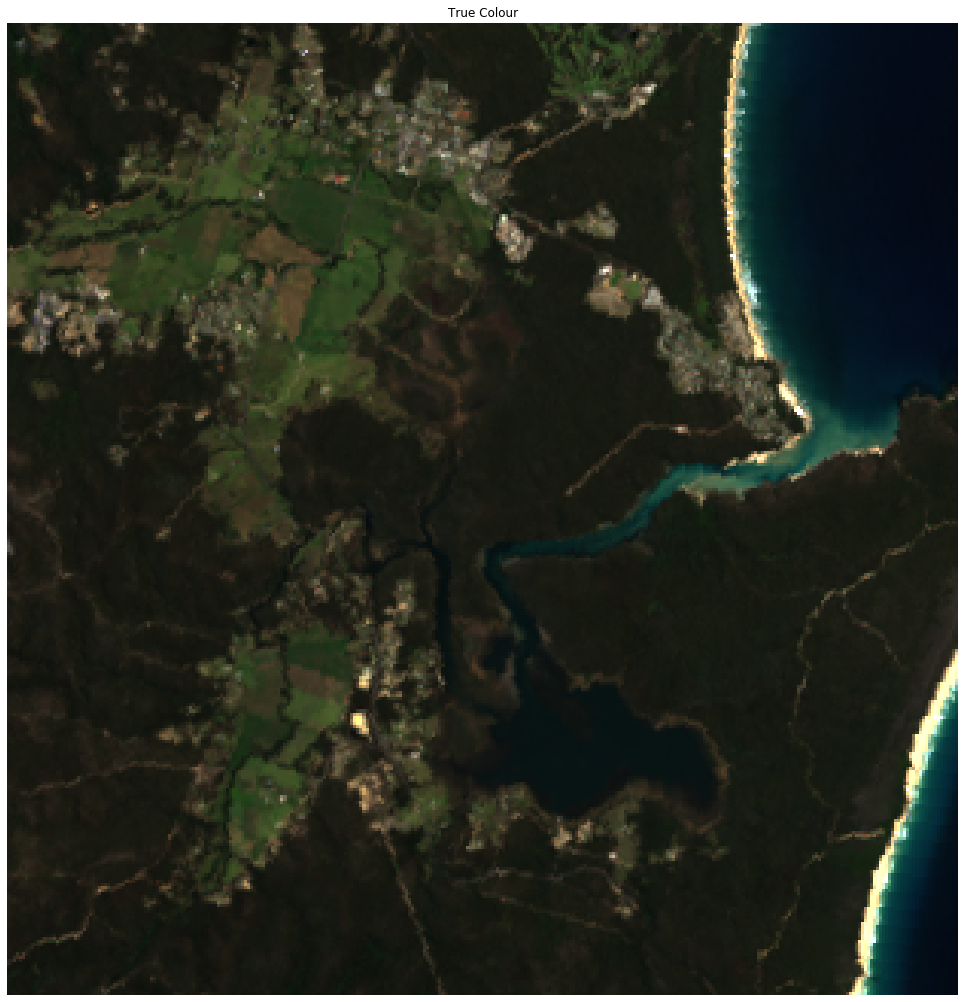

In [23]:
data_lst8_once = Masked_lst8_data.isel(time=4)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 3000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [19]:
lst_fisher = 1.7204 +((171*Masked_lst8_data['green'])+(3*Masked_lst8_data['red'])-(70*Masked_lst8_data['nir'])-(45*Masked_lst8_data['swir1'])-(71*Masked_lst8_data['swir2']))/10000
lst_fisher

<xarray.DataArray (time: 11, y: 320, x: 313)>
array([[[-19.8673, -19.0042, ...,   3.4124,   3.4053],
        [-22.7548, -19.6263, ...,   3.4028,   3.4387],
        ...,
        [-17.559 , -14.5333, ...,   3.3831,   3.3896],
        [-14.1751, -13.5119, ...,   3.4131,   3.3668]],

       [[-17.0632,      nan, ...,   3.4348,   3.7016],
        [-17.5758,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,   2.7752,      nan],
        [     nan,      nan, ...,   2.5499,   2.7642]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]]])
C

(array([1.7400e+02, 1.2833e+04, 5.3458e+04, 1.6690e+04, 7.5650e+03,
        7.8550e+03, 1.2870e+03, 2.1100e+02, 5.8000e+01, 8.0000e+00]),
 array([-46.0197 , -35.85228, -25.68486, -15.51744,  -5.35002,   4.8174 ,
         14.98482,  25.15224,  35.31966,  45.48708,  55.6545 ]),
 <a list of 10 Patch objects>)

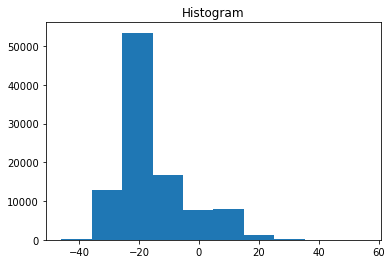

In [24]:
lst_fisher.isel(time=4).plot.hist()

In [21]:
wet_water = lst_fisher.where(lst_fisher>=-10,-1)
wet_water = wet_water.where(lst_fisher<-10,1)

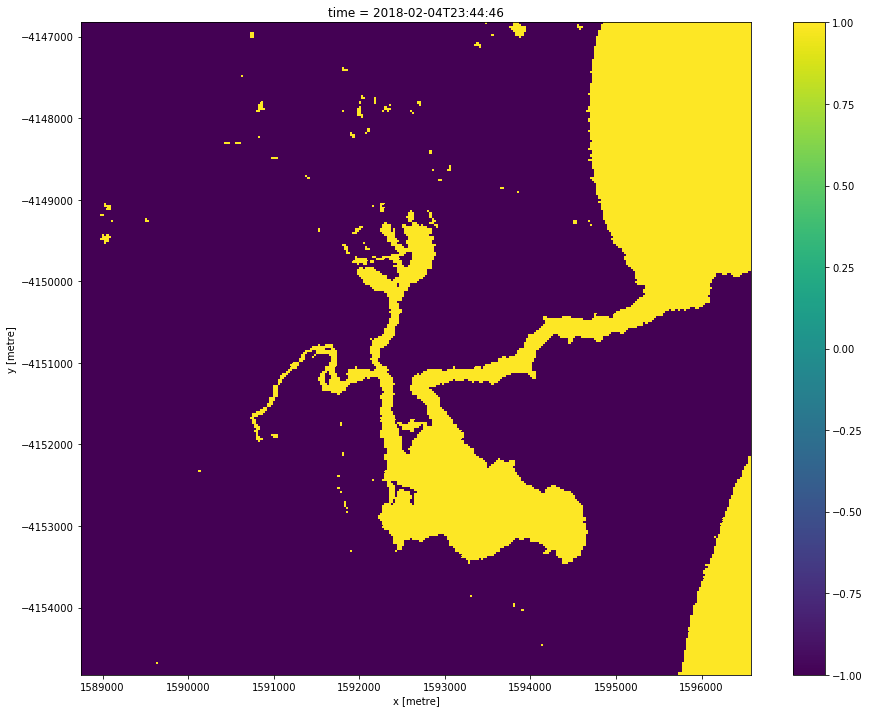

In [25]:
wet_water.isel(time=4).plot(cmap='viridis', figsize =(15,12))